# Mask R-CNN - Kovid Maske testiranje

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!cp -r /content/gdrive/MyDrive/Mask_RCNN_modifikacija/ /content

## Instaliranje paketa
Svi paketi koji su potrebni za pokretanje projekta nalaze se u fajlu requirements.txt


In [3]:
!pip install -r /content/Mask_RCNN_modifikacija/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 1.3 MB/s 
     |████████████████████████████████| 336 kB 56.4 MB/s 
     |████████████████████████████████| 2.9 MB 37.7 MB/s 
     |████████████████████████████████| 3.2 MB 48.7 MB/s 
     |████████████████████████████████| 367 kB 56.1 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 1.6 MB 53.4 MB/s 
     |████████████████████████████████| 298 kB 59.4 MB/s 
     |████████████████████████████████| 154 kB 63.8 MB/s 
     |████████████████████████████████| 120 kB 64.1 MB/s 
     |████████████████████████████████| 82 kB 555 kB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling t

Trenirani modeli nalaze se u folderu logs.
Moduli koji su potrebni za testiranje modela su:


*   mrcnn
*   covid_mask



In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import importlib.util
import sys
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN_modifikacija")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

spec = importlib.util.spec_from_file_location("covid_mask", "/content/Mask_RCNN_modifikacija/covid_mask/covid_mask.py")
covid_mask = importlib.util.module_from_spec(spec)
sys.modules["covid_mask"] = covid_mask
spec.loader.exec_module(covid_mask)
covid_mask.CovidMaskConfig()
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Covid mask trained weights
COVID_MASK_WEIGHTS_PATH = "/Mask_RCNN_modifikacija/mask_rcnn_covid_mask.h5"  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Konfiguracija
U folderu dataset nalazi se folder val u kojem su slike koje će biti korišćene za testiranje

In [5]:
config = covid_mask.CovidMaskConfig()
COVID_MASK_DIR = os.path.join(ROOT_DIR, "dataset")

In [6]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Da bi se model testirao potrebno je postaviti mode na vrednost inference (zaključivanje).

In [7]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
TEST_MODE = "inference"

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


## Učitavanje podataka za testiranje

In [9]:
# Load validation dataset
dataset = covid_mask.CovidMaskDataset()
dataset.load_covid_mask(COVID_MASK_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 47
Classes: ['BG', 'covid_mask']


## Kreiranje modela u inference modu

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Colocations handled automatically by placer.


fpn_classifier_graph
Tensor("ROI/packed_2:0", shape=(1, ?, 4), dtype=float32, device=/device:CPU:0)
[<tf.Tensor 'fpn_p2/BiasAdd:0' shape=(?, ?, ?, 256) dtype=float32>, <tf.Tensor 'fpn_p3/BiasAdd:0' shape=(?, ?, ?, 256) dtype=float32>, <tf.Tensor 'fpn_p4/BiasAdd:0' shape=(?, ?, ?, 256) dtype=float32>, <tf.Tensor 'fpn_p5/BiasAdd:0' shape=(?, ?, ?, 256) dtype=float32>]
Tensor("input_image_meta:0", shape=(?, 14), dtype=float32, device=/device:CPU:0)
7
2
False
X
Tensor("mrcnn_bbox_fc/Reshape_1:0", shape=(?, 1000, 8), dtype=float32, device=/device:CPU:0)
MRCNN_BBOX
Tensor("mrcnn_bbox/Reshape:0", shape=(?, 1000, 2, 4), dtype=float32, device=/device:CPU:0)


Instructions for updating:
Use tf.cast instead.


### Učitavanje poslednjeg modela 

In [15]:
weights_path = "/content/Mask_RCNN_modifikacija/mask_rcnn_covid_mask_0001.h5"

# Or, load the last model you trained
#weights_path = model.find_last()
#weights_path = model.get_imagenet_weights()
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True, exclude=["mrcnn_bbox_fc", "mrcnn_class_logits", "mrcnn_mask"])

Loading weights  /content/Mask_RCNN_modifikacija/mask_rcnn_covid_mask_0001.h5
load_weights
A
LOAD FILE
LOAD FILE1
LOAD FILE2
LOAD FILE3


## Testiranje modela
Bira se slika iz skupa za testiranje na kojoj se vrši predikcija.

image ID: covid_mask.maksssksksss770.png (26) /content/Mask_RCNN_modifikacija/dataset/train/maksssksksss770.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  207.00000  max:  453.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


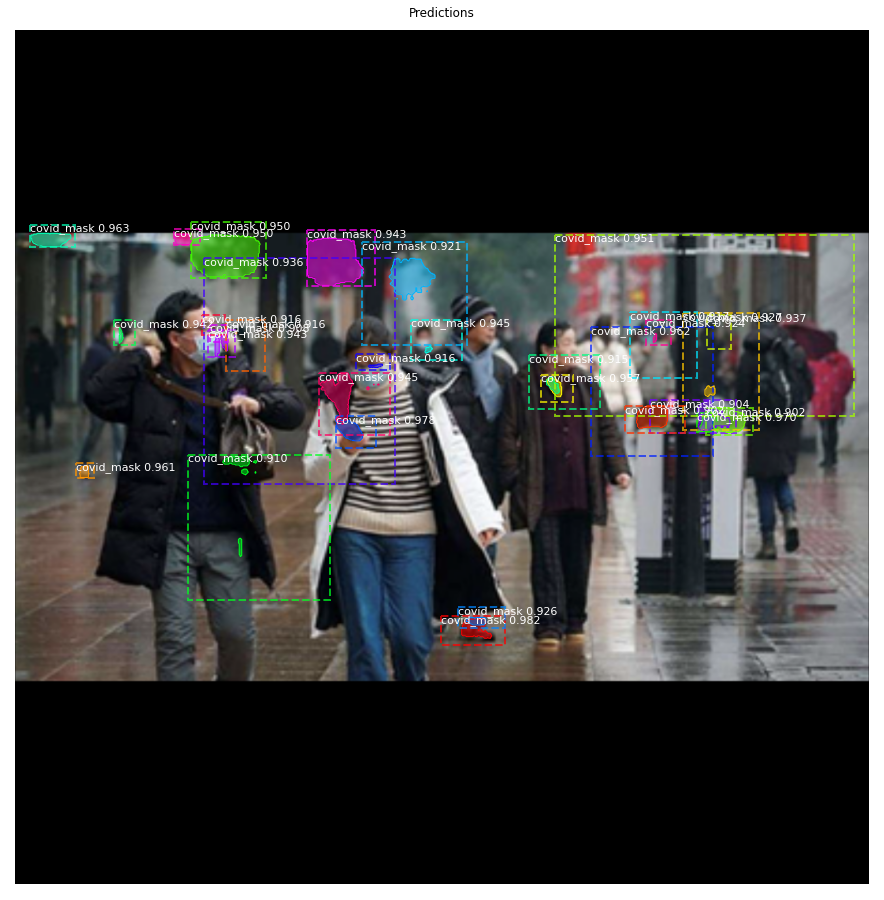

In [17]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## RPN Mreža


### RPN Target
Slika se podeli na delove (sidra) koji pokrivaju celu sliku. Za svaki deo se računa IoU.  

In [18]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -3.31456  max:    3.75650  float64
positive_anchors         shape: (15, 4)               min:  208.68629  max:  452.00000  float64
negative_anchors         shape: (241, 4)              min: -192.00000  max: 1152.00000  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (15, 4)               min:  207.00000  max:  453.00000  float32


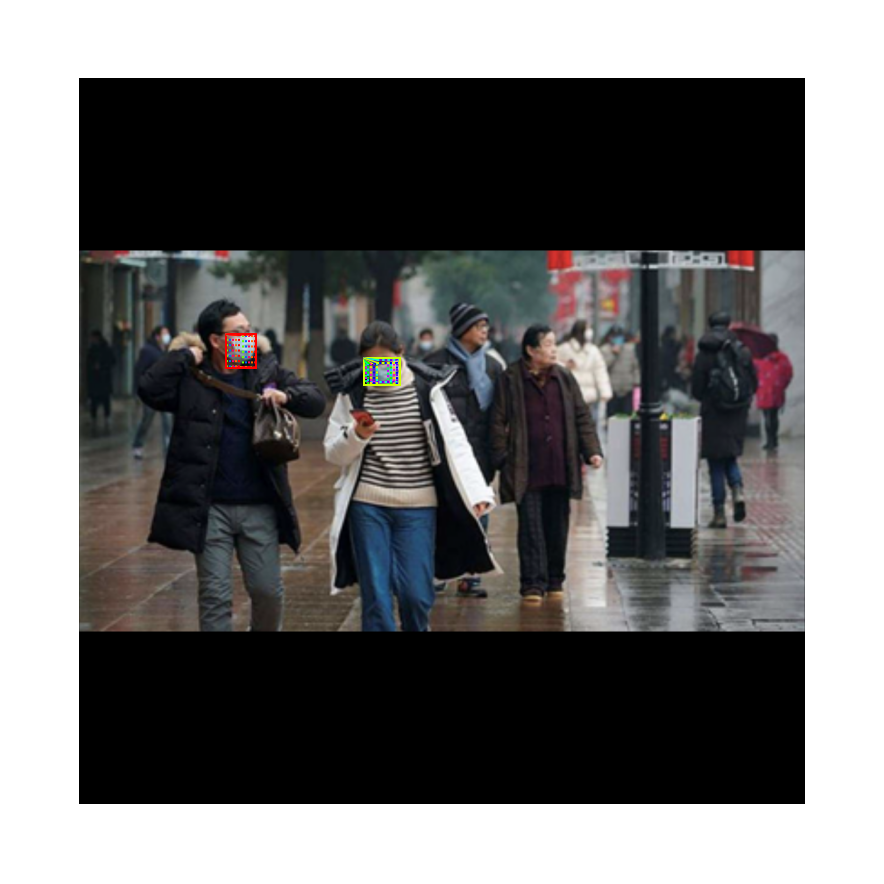

In [19]:
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### RPN Predikcija

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

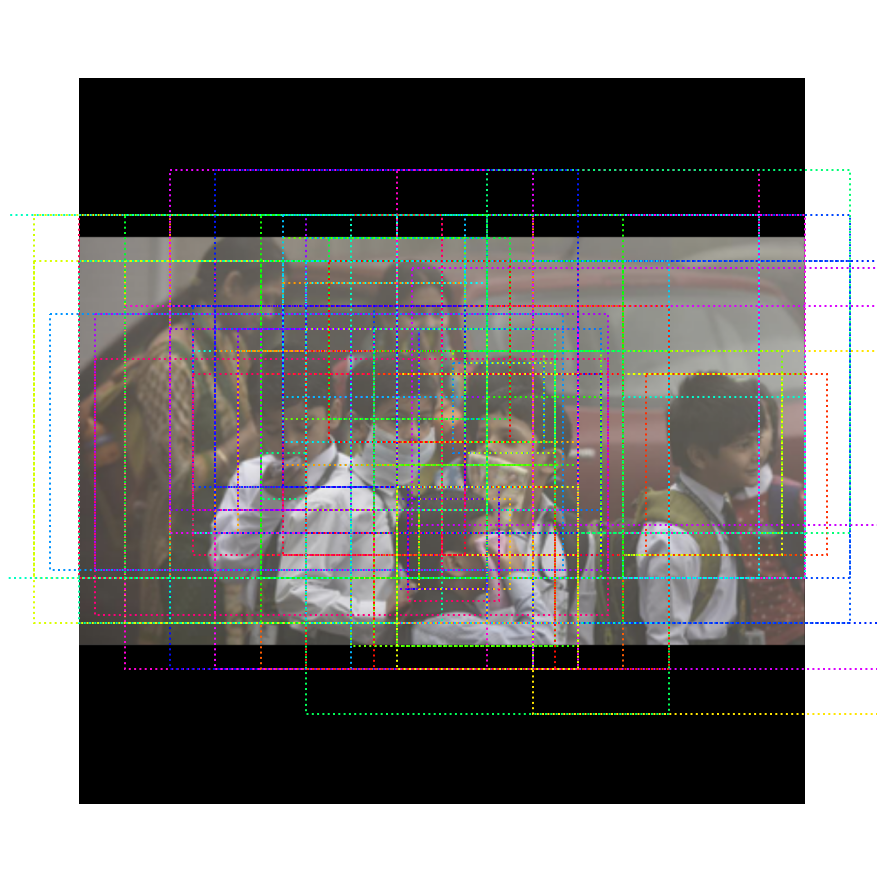

In [ ]:
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

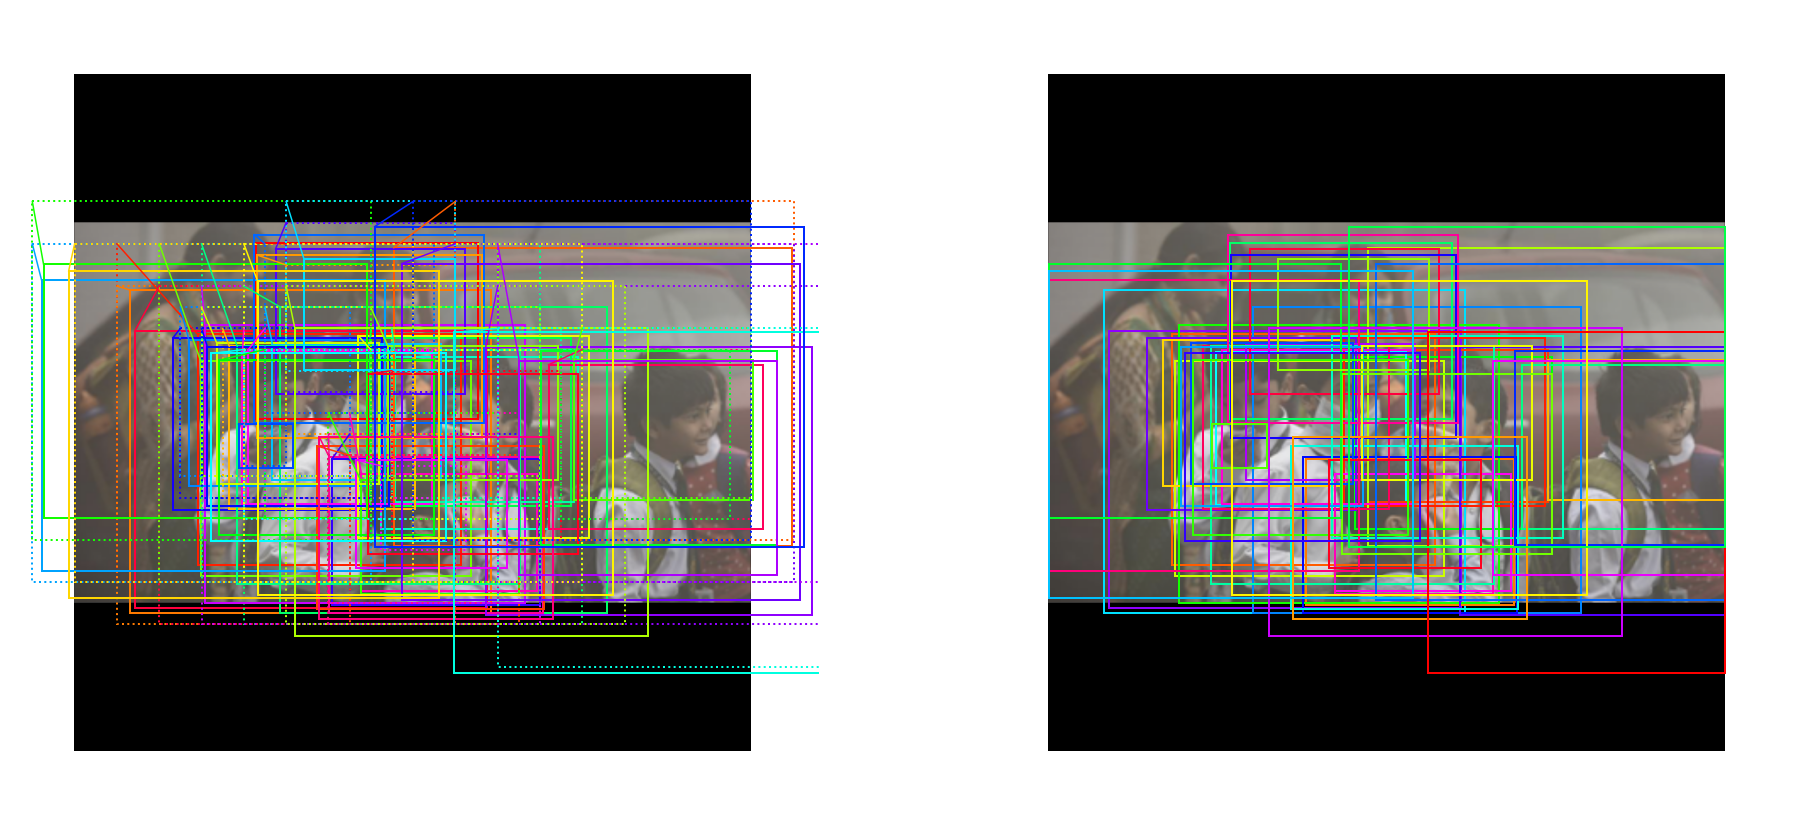

In [ ]:
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

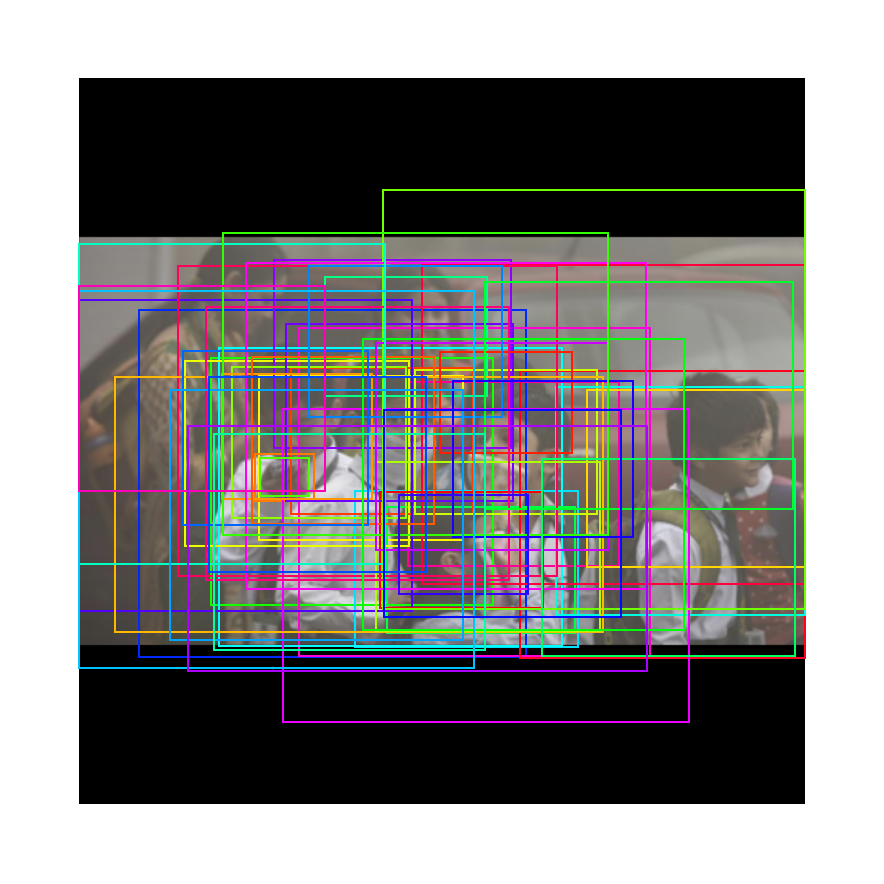

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

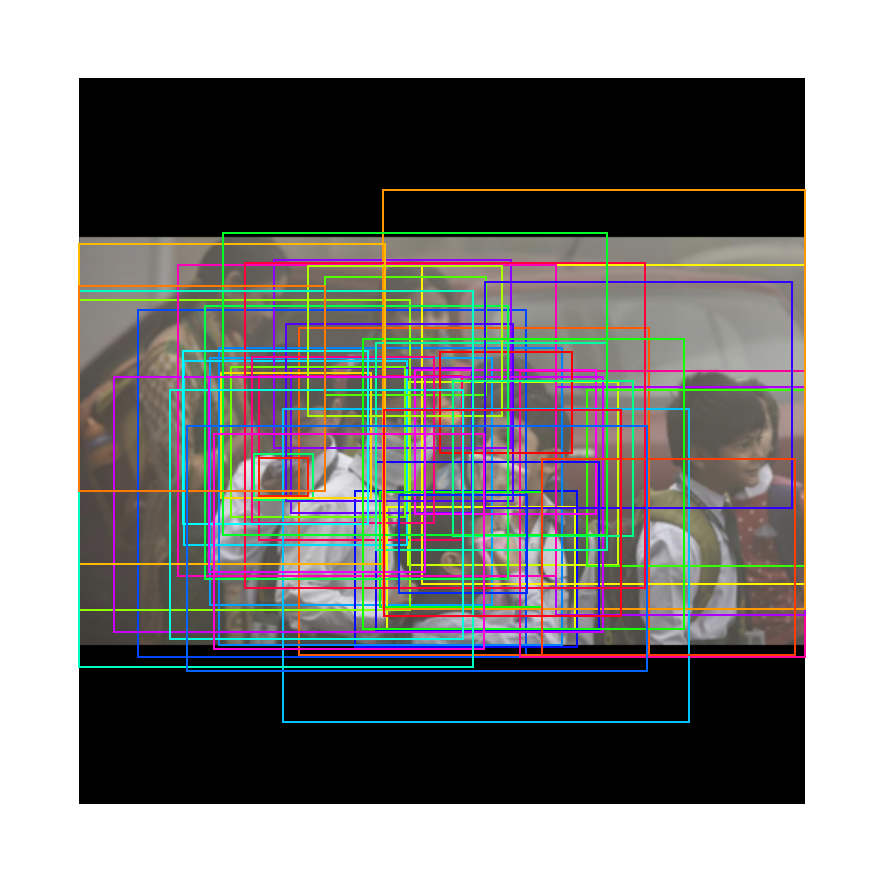

In [ ]:
limit = 50
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Klasifikacija
U ovoj fazi se uzimaju predlozi regiona iz RPN-a i klasifikuju se.

Generisanje verovatnoće klasa i regresije graničnih okvira.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00160  max:    0.99840  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -3.65170  max:    3.82390  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.03054  max:    0.99990  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


3 detections: ['covid_mask' 'covid_mask' 'covid_mask']


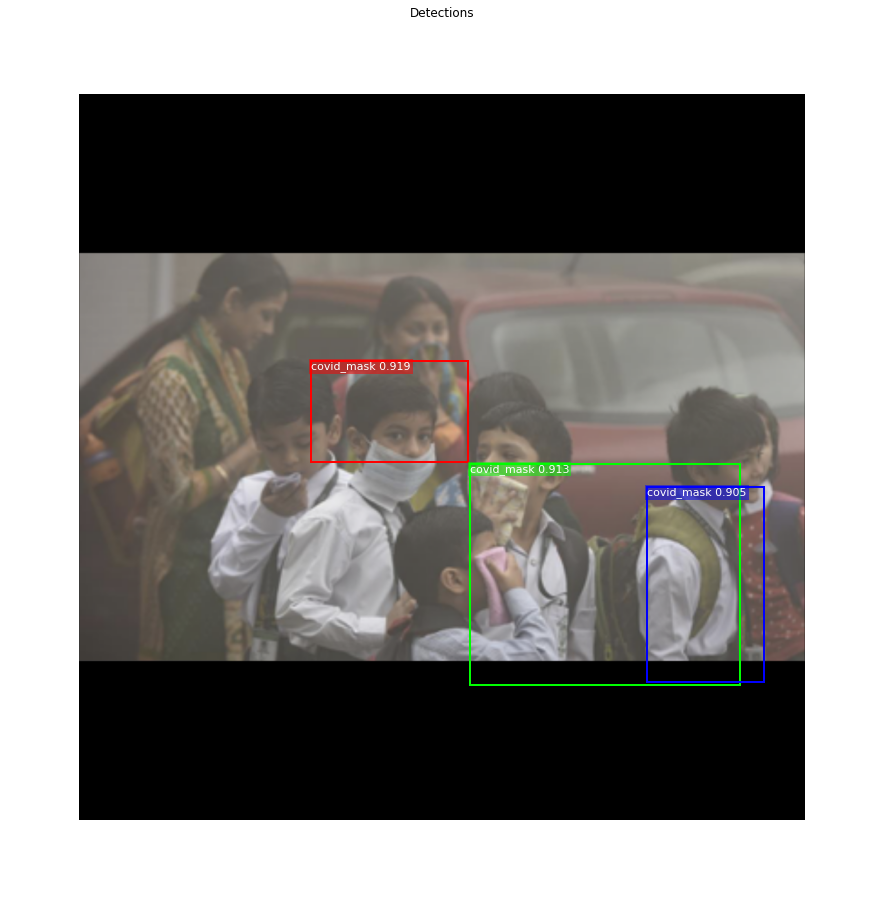

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### Proces obrade detekcije maski

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
193 Positive ROIs
[('BG', 807), ('covid_mask', 193)]


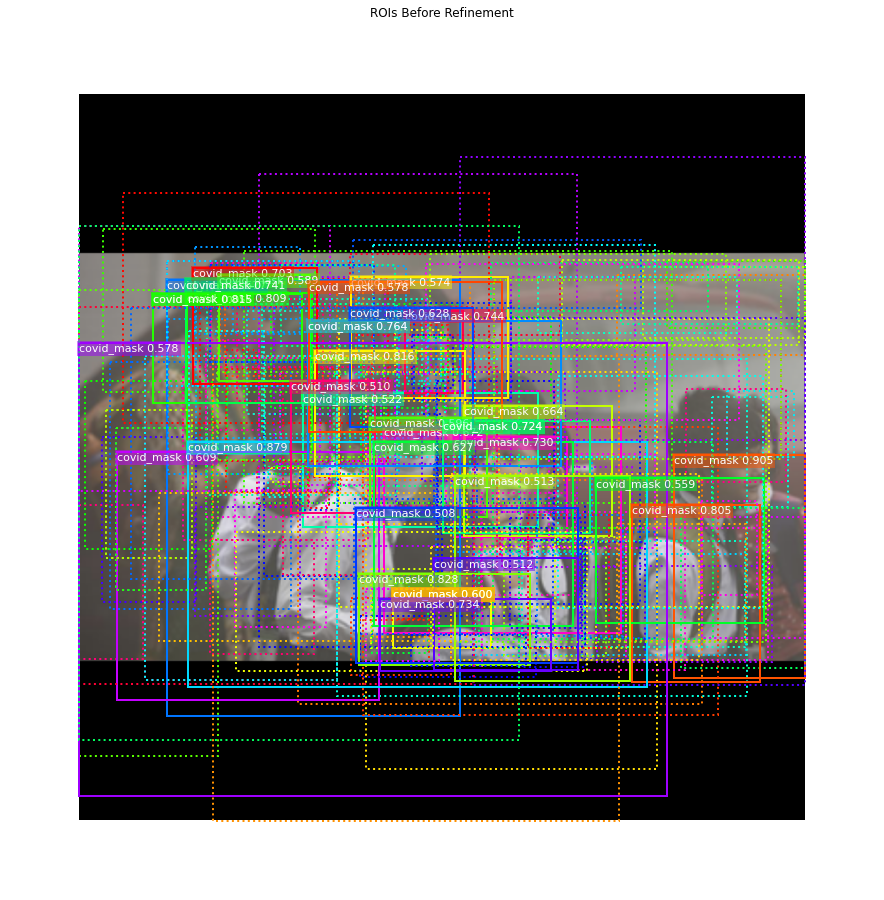

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

Prečišćavanje graničnog okvira

roi_bbox_specific        shape: (1000, 4)             min:   -3.65170  max:    2.98328  float32
refined_proposals        shape: (1000, 4)             min: -229.00000  max: 1079.00000  int32


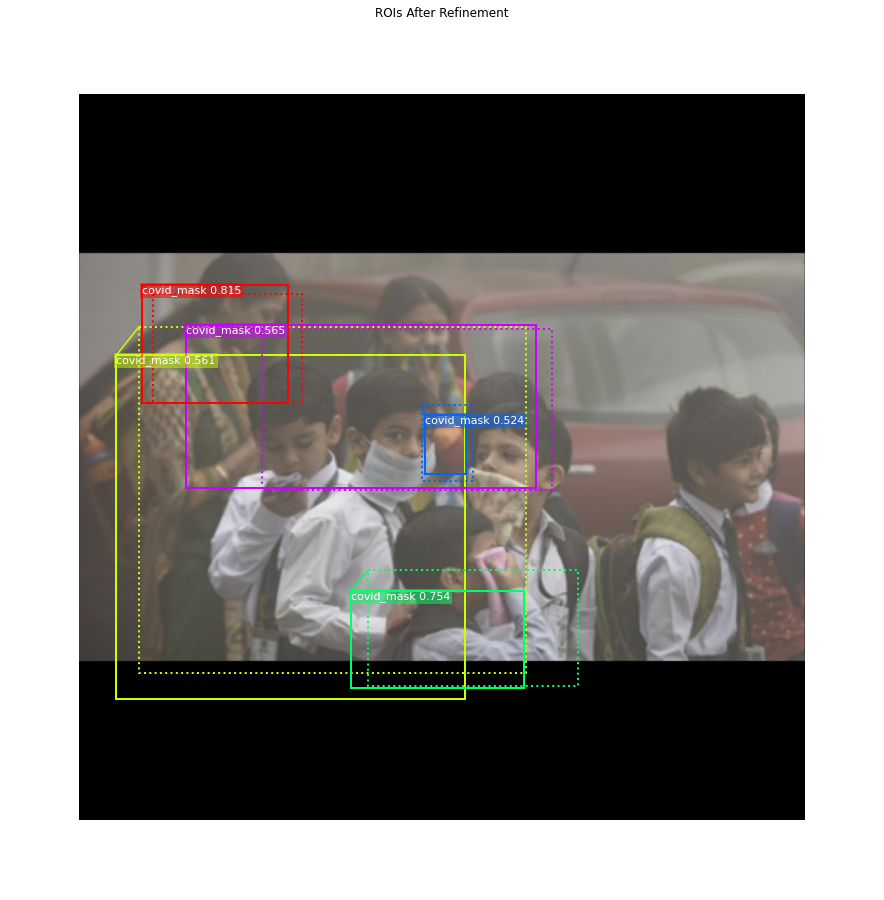

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

Pronalaženje detekcija koje imaju nisku pouzdanost

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 193 detections:
[  1   2   3   5  11  18  19  21  23  32  40  42  43  48  49  50  52  54
  63  72  77  79  83  87  88  94  96  97  98 100 106 112 122 124 133 134
 135 136 137 140 142 143 144 147 149 151 157 160 162 170 180 189 193 197
 204 208 213 220 221 225 230 233 237 238 245 249 256 270 271 278 285 286
 288 289 290 292 312 313 316 317 318 324 329 330 345 347 352 355 357 360
 363 371 375 376 386 389 393 398 402 406 409 415 419 431 433 436 441 444
 463 466 469 479 481 486 488 495 514 516 517 519 520 531 532 537 538 562
 565 574 576 577 580 585 587 588 590 599 613 618 620 623 629 654 655 666
 688 695 701 702 704 707 708 712 716 717 723 729 733 739 744 746 750 762
 770 780 790 794 804 807 830 833 844 848 852 861 867 868 879 883 893 895
 896 904 916 924 925 931 940 952 968 986 987 990 992]


In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

covid_mask            : [  1   2   3   5  11  18  19  21  23  32  40  42  43  48  49  50  52  54
  63  72  77  79  83  87  88  94  96  97  98 100 106 112 122 124 133 134
 135 136 137 140 142 143 144 147 149 151 157 160 162 170 180 189 193 197
 204 208 213 220 221 225 230 233 237 238 245 249 256 270 271 278 285 286
 288 289 290 292 312 313 316 317 318 324 329 330 345 347 352 355 357 360
 363 371 375 376 386 389 393 398 402 406 409 415 419 431 433 436 441 444
 463 466 469 479 481 486 488 495 514 516 517 519 520 531 532 537 538 562
 565 574 576 577 580 585 587 588 590 599 613 618 620 623 629 654 655 666
 688 695 701 702 704 707 708 712 716 717 723 729 733 739 744 746 750 762
 770 780 790 794 804 807 830 833 844 848 852 861 867 868 879 883 893 895
 896 904 916 924 925 931 940 952 968 986 987 990 992] -> [562  40 220 313 386  49 861 137 780 398 904 289 968 330 916 133 151 844
 488 739 237 270 574]

Kept after per-class NMS: 23
[ 40  49 133 137 151 220 237 270 289 313 330 386 398 488 562 574

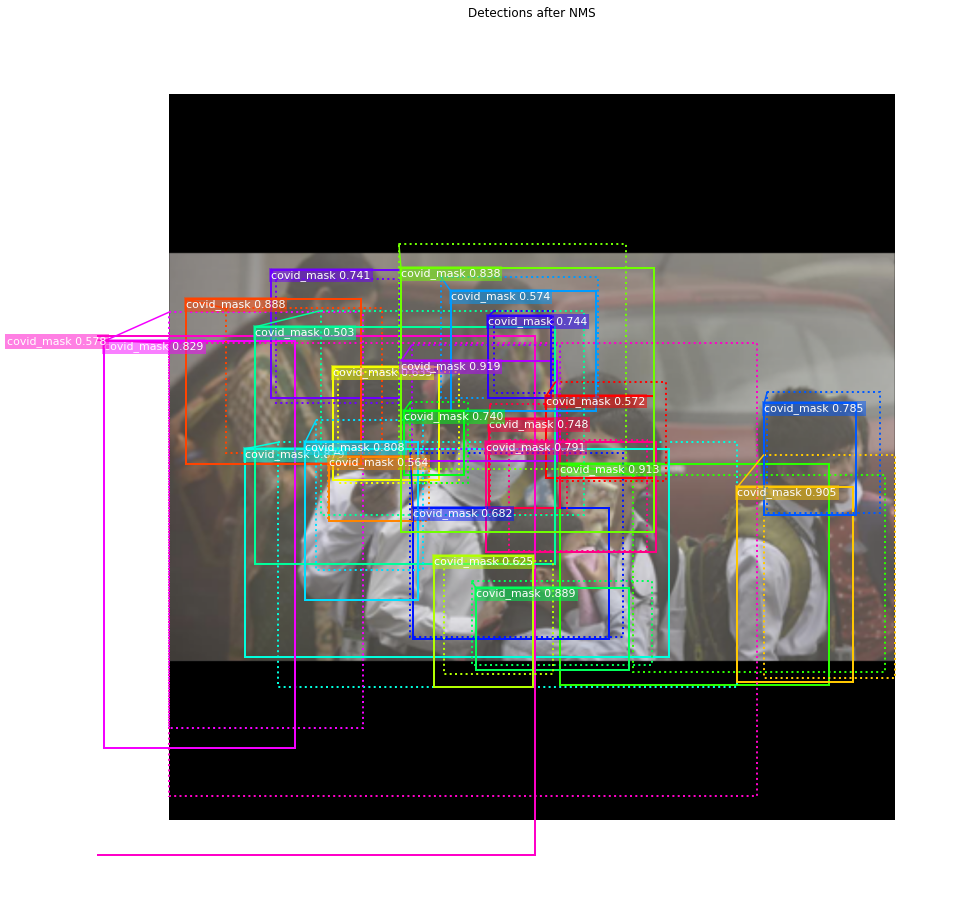

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Generisanje Maske
U ovoj fazi se uzimaju detekcije (prečišćene granične okvire i ID-ove klasa) iz prethodnog sloja i generišu maske segmentacije za svaku instancu.

### Target Za Maske

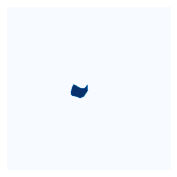

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.03054  max:    0.99990  float32
3 detections: ['covid_mask' 'covid_mask' 'covid_mask']


In [ ]:
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (3, 28, 28)           min:    0.12240  max:    0.99990  float32
det_masks                shape: (3, 1024, 1024)       min:    0.00000  max:    1.00000  bool


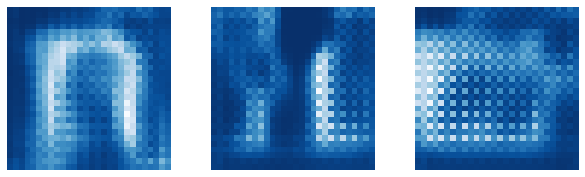

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

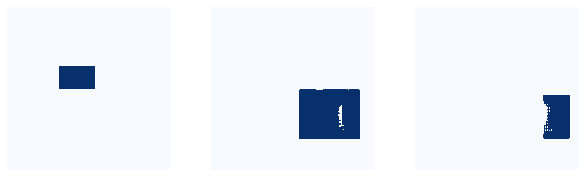

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")